In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
crsp=pd.read_csv('sp500data.csv')
crsp.head()

,PERMNO,start,ending,DATE,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SHROUT
0,10006,1957-03-01,1984-07-18,1970-01-30,10.0,1.0,3743.0,46.375,760.0,-0.053571,5641.0
1,10006,1957-03-01,1984-07-18,1970-02-27,10.0,1.0,3743.0,48.125,909.0,0.050674,5641.0
2,10006,1957-03-01,1984-07-18,1970-03-31,10.0,1.0,3743.0,49.250,499.0,0.023377,5641.0
3,10006,1957-03-01,1984-07-18,1970-04-30,10.0,1.0,3743.0,45.500,533.0,-0.076142,5641.0
4,10006,1957-03-01,1984-07-18,1970-05-29,10.0,1.0,3743.0,38.500,609.0,-0.140659,5641.0


In [3]:
crsp = crsp.loc[(crsp['SHRCD'] == 10)|(crsp['SHRCD'] == 11)]

In [4]:
crsp['DATE'] = pd.to_datetime(crsp['DATE'])
crsp['DATE'] = crsp['DATE'] + MonthEnd(0)
crsp['PRC']  = np.abs(crsp['PRC'])
crsp['MV'] = crsp['SHROUT']*crsp['PRC']
crsp.drop(['start','ending','SHRCD','EXCHCD','SICCD'], axis=1, inplace=True)
crsp.set_index(['PERMNO','DATE'], inplace=True)
crsp.sort_index(inplace=True)

In [5]:
cpst=pd.read_csv('sp500compustat_all.csv')

cpst['datadate'] = pd.to_datetime(cpst['datadate'])
cpst['DATE'] = cpst['datadate'] + MonthEnd(0)
cpst.drop(columns=['LPERMNO','start','ending','Index'],inplace=True)
cpst.set_index(['PERMNO','DATE'], inplace=True)
cpst.sort_index(inplace=True)
cpst.head()

datadate  fyear      act       at    capx      ceq  \
PERMNO DATE                                                              
10006  1970-12-31 1970-12-31   1970  134.101  470.518  51.670  195.671   
       1971-12-31 1971-12-31   1971  137.548  497.393  38.339  198.908   
       1972-12-31 1972-12-31   1972  135.154  506.785  30.836  203.794   
       1973-12-31 1973-12-31   1973  175.075  580.766  59.182  217.913   
       1974-12-31 1974-12-31   1974  226.296  675.170  70.721  235.747   

                      che     cogs     dlc     dltt  ...   oibdp    ppent  \
PERMNO DATE                                          ...                    
10006  1970-12-31  15.499  238.889   3.014  175.944  ...  66.179  317.120   
       1971-12-31  13.409  238.345   2.304  192.069  ...  64.169  328.953   
       1972-12-31  19.955  242.330   0.910  178.629  ...  68.737  334.357   
       1973-12-31  10.319  321.079  22.169  189.111  ...  79.492  365.068   
       1974-12-31   9.107  401.983  37.441  223.341  ...  92.630  405.694   

                   pstk  pstkrv     revt      seq    txp    xint    xsga  \
PERMNO DATE                                                                
10006  1970-12-31   0.0     0.0  333.718  195.671  3.253  11.354  28.650   
       1971-12-31   0.0     0.0  332.704  198.908  3.359  13.084  30.190   
       1972-12-31   0.0     0.0  343.679  203.794  4.823  13.247  32.612   
       1973-12-31   0.0     0.0  436.146  217.913  6.339  14.976  35.575   
       1974-12-31   0.0     0.0  535.097  235.747  4.843  20.146  40.484   

                   mkvalt  
PERMNO DATE                
10006  1970-12-31     NaN  
       1971-12-31     NaN  
       1972-12-31     NaN  
       1973-12-31     NaN  
       1974-12-31     NaN  

[5 rows x 26 columns]

In [6]:
crsp = crsp.sort_values(by = ['PERMNO','DATE','MV'], ascending = [True, True, False])
cpst  = cpst.sort_values(by = ['PERMNO','DATE','seq'], ascending = [True, True, False])

crsp = crsp.groupby(['PERMNO','DATE']).head(1)
cpst = cpst.groupby(['PERMNO','DATE']).head(1)

In [7]:
data_orig = crsp.merge(cpst, how='left', on=['PERMNO','DATE'])

## Feature Engineering

#### Valuation

Book value of equity (BE(t)): seq(t) OR ceq(t) + pstk(t) OR at(t) - lt(t)

Book-to-market ratio: BE(t) / MV(t)

Cash flow-to-price ratio: (ib(t) + dp(t)) / MV(t)

Earnings-price ratio: ib(t) / MV(t)

Total enterprise value (TEV(t)): MV(t) + dlc(t) + dltt(t) + pstkrv(t) - che(t)

Enterprise multiple: TEV(t) / oibdp(t)

Sales-to-price ratio: revt(t) / MV(t)

#### Profitability
Gross profitability: (revt(t) - cogs(t)) / at(t)

Operating profitability: (revt(t) - cogs(t) - xsga(t) - xint(t)) / BE(t)

Return on assets: ib(t) / at(t)

Return on equity: ib(t) / BE(t)

Profit margin: oiadp(t) / revt(t)

#### Investment		
Asset growth: at(t) / at(t-4) - 1

Inventory growth: Δinvt(t) / at(t-4)

Sales growth: Δrevt(t) / at(t-4)

Investment growth rate: capx(t) / capx(t-1) - 1

Investment to capital ratio: capx(t) / ppent(t-1)

Investments to assets ratio: (Δpent(t) + Δinvt(t)) / at(t-4)
		
#### Quality		
Accruals: (Δact(t) - Δche(t) - Δlct(t) - Δdlc(t) - Δtxp(t) - dp(t)) / at(t-4)

Net operating assets: (at(t) - che(t) - at(t) + dlc(t) + dltt(t) + BE(t)) / at(t-4)

Net working capital changes: (Δact(t) - Δche(t) - Δlct(t) + Δdlc(t)) / at(t-4)
		
#### Financing		
Debt issuance: (Δdlc(t) + Δdltt(t)) / TEV(t-4)

Leverage: dltt(t) / BE(t)

In [8]:
data = data_orig.copy()

In [9]:
# Valuation variables

# book value of equity
data['BE'] = data['seq'].apply(lambda x: 1 if x==0 else x)
# book to market value ratio
data['lag_BM'] = data['BE'].groupby('PERMNO').shift(6)/data['MV'].groupby('PERMNO').shift()*1000
# cash flow to price ratio
data['lag_CFP'] = (data['ib'].groupby('PERMNO').shift(6) + 
                   data['dp'].groupby('PERMNO').shift(6))/data['MV'].groupby('PERMNO').shift()*1000
# earninigs to price ratio
data['lag_EP'] = data['ib'].groupby('PERMNO').shift(6) / data['MV'].groupby('PERMNO').shift()*1000
# total enterprise value
data['lag_TEV'] = (data['MV'].groupby('PERMNO').shift()*1000 + 
                   data['dlc'].groupby('PERMNO').shift(6) + 
                   data['dltt'].groupby('PERMNO').shift(6) +
                   data['pstkrv'].groupby('PERMNO').shift(6) - 
                   data['che'].groupby('PERMNO').shift(6))
# enterprise multiple
data['lag_EM'] = data['lag_TEV']/data['oibdp'].groupby('PERMNO').shift(6)
# sales to price ratio
data['lag_SP'] = data['revt'].groupby('PERMNO').shift(6)/data['MV'].groupby('PERMNO').shift()*1000

In [10]:
# Profitability Variables

# Gross Profitability
data['lag_GP'] = (data['revt'].groupby('PERMNO').shift(6) - data['cogs'].groupby('PERMNO').shift(6))
# Operating Profitability
data['lag_OP'] = (data['revt'].groupby('PERMNO').shift(6) - 
              data['cogs'].groupby('PERMNO').shift(6) - 
              data['xsga'].groupby('PERMNO').shift(6) - 
              data['xint'].groupby('PERMNO').shift(6))/data['BE'].groupby('PERMNO').shift(6)
# Return on Assets
data['lag_ROA'] = data['ib'].groupby('PERMNO').shift(6) / data['at'].groupby('PERMNO').shift(6)
# Return on Equity 
data['lag_ROE'] = data['ib'].groupby('PERMNO').shift(6) / data['BE'].groupby('PERMNO').shift(6)
# Profit Margin
data['lag_PM'] = data['oiadp'].groupby('PERMNO').shift(6) / data['revt'].groupby('PERMNO').shift(6)

In [11]:
# Investment Variables

# Lag Variables for previous year (4 quarters, 12 months)
data['lag_at']=data['at'].groupby('PERMNO').shift(12)
data['lag_invt']=data['invt'].groupby('PERMNO').shift(12)
data['lag_revt']=data['revt'].groupby('PERMNO').shift(12)
data['lag_capx']=data['capx'].groupby('PERMNO').shift(12)
data['lag_ppent']=data['ppent'].groupby('PERMNO').shift(12)

# Asset Growth
data['lag_AG'] = data['at'].groupby('PERMNO').shift(6)/data['lag_at'].groupby('PERMNO').shift(6)-1
# Inventory Growth
data['lag_IG'] = (data['invt'].groupby('PERMNO').shift(6) - 
               data['lag_invt'].groupby('PERMNO').shift(6))/data['lag_at'].groupby('PERMNO').shift(6)
# Sales Growth
data['lag_SG'] = (data['revt'].groupby('PERMNO').shift(6) - 
                  data['lag_revt'].groupby('PERMNO').shift(6))/data['lag_at'].groupby('PERMNO').shift(6)
# Investment Growth Rate
data['lag_IVG'] = data['lag_capx'].groupby('PERMNO').shift(6)/data['capx'].groupby('PERMNO').shift(6)-1
# Investment to Capital Ratio
data['lag_IC'] = data['lag_capx'].groupby('PERMNO').shift(6)/data['ppent'].groupby('PERMNO').shift(6)
# Investments to Assets Ratio
data['lag_IA'] = ((data['ppent'].groupby('PERMNO').shift(6) - 
                   data['lag_ppent'].groupby('PERMNO').shift(6)) + 
                  (data['invt'].groupby('PERMNO').shift(6) - 
                   data['lag_invt'].groupby('PERMNO').shift(6)))/data['lag_at'].groupby('PERMNO').shift(6)

In [12]:
# Quality Variables

# Lag variables for previous year (4 quarters, 12 months)
data['lag_act'] = data['act'].groupby('PERMNO').shift(12)
data['lag_che'] = data['che'].groupby('PERMNO').shift(12)
data['lag_lct'] = data['lct'].groupby('PERMNO').shift(12)
data['lag_dlc'] = data['dlc'].groupby('PERMNO').shift(12)
data['lag_txp'] = data['txp'].groupby('PERMNO').shift(12)

# Accruals
data['lag_Accruals'] = ((data['act'].groupby('PERMNO').shift(6) - data['lag_act'].groupby('PERMNO').shift(6)) - 
                        (data['che'].groupby('PERMNO').shift(6) - data['lag_che'].groupby('PERMNO').shift(6)) - 
                        (data['lct'].groupby('PERMNO').shift(6) - data['lag_lct'].groupby('PERMNO').shift(6)) - 
                        (data['dlc'].groupby('PERMNO').shift(6) - data['lag_dlc'].groupby('PERMNO').shift(6)) - 
                        (data['txp'].groupby('PERMNO').shift(6) - data['lag_txp'].groupby('PERMNO').shift(6)) -
                        (data['dp'].groupby('PERMNO').shift(6)))/data['lag_at'].groupby('PERMNO').shift(6)

# Net Operating Assets
data['lag_NOA'] = (data['at'].groupby('PERMNO').shift(6) - 
                   data['che'].groupby('PERMNO').shift(6) - 
                   data['at'].groupby('PERMNO').shift(6) + 
                   data['dlc'].groupby('PERMNO').shift(6) + 
                   data['dltt'].groupby('PERMNO').shift(6) + 
                   data['BE'].groupby('PERMNO').shift(6))/data['lag_at'].groupby('PERMNO').shift(6)

# Net Working Capital Changes
data['lag_NWCC'] = ((data['act'].groupby('PERMNO').shift(6) - data['lag_act'].groupby('PERMNO').shift(6)) - 
                    (data['che'].groupby('PERMNO').shift(6) - data['lag_che'].groupby('PERMNO').shift(6)) - 
                    (data['lct'].groupby('PERMNO').shift(6) - data['lag_lct'].groupby('PERMNO').shift(6)) +
                    (data['dlc'].groupby('PERMNO').shift(6) - data['lag_dlc'].groupby('PERMNO').shift(6)))/data['lag_at'].groupby('PERMNO').shift(6)

In [13]:
# Financing Variables

# Lag variables for previous year (4 quarters, 12 months)
data['lag_dltt'] = data['dltt'].groupby('PERMNO').shift(12)
data['lag_lag_TEV'] = data['lag_TEV'].groupby('PERMNO').shift(12)

# Debt Issuance
data['lag_DI'] = ((data['dlc'].groupby('PERMNO').shift(6) - data['lag_dlc'].groupby('PERMNO').shift(6)) + 
                   (data['dltt'].groupby('PERMNO').shift(6) - data['lag_dltt'].groupby('PERMNO').shift(6)))/(data['lag_lag_TEV'].groupby('PERMNO').shift(6))

# Leverage
data['lag_Leverage'] = data['dltt'].groupby('PERMNO').shift(6)/data['BE'].groupby('PERMNO').shift(6)

In [14]:
data = data.groupby('PERMNO').fillna(method='pad', limit=15)

In [15]:
# make sure all target variables have non null values
df = data[['RET','VOL','PRC','SHROUT','MV','lag_BM', 'lag_CFP', 'lag_EP', 'lag_TEV', 'lag_EM',
       'lag_SP', 'lag_GP', 'lag_OP', 'lag_ROA', 'lag_ROE', 'lag_PM','lag_AG', 'lag_IG',
       'lag_SG', 'lag_IVG','lag_IC', 'lag_IA', 'lag_Accruals', 'lag_NOA', 'lag_NWCC', 'lag_Leverage']]
# df = df.dropna()

In [16]:
df.to_csv('finaldata.csv')

In [17]:
def perf(sortvar):
    
    # creating the quintiles
    df['Q'] = df.groupby('DATE')[sortvar].apply(quintiles)
    
    # computing quintile portfolio returns
    ports = df.groupby(['Q','DATE'])['RET'].mean()
    
    # printing out basic statistics on each portfolio
    print(ports.groupby('Q').describe())
    
    # computing high minus low portfolios
    hml = ports.loc[5] - ports.loc[1]
    
    return hml

def stats(hml):
    # printing basic statistics plus sharpe and t-stat
    stats = hml.describe()
    stats.loc['tstat']  = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)    
    return stats
    
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [89]:
df = pd.read_csv('finaldata.csv')

In [90]:
df['lag_RET'] = df.groupby('PERMNO')['RET'].shift()
df = df.dropna(subset=['lag_RET'])

In [91]:
# df = df.reset_index()
df = df.loc[df.DATE > '1992-06-30'] 

I will want to exclude all stocks with E/P below 0 or above .5. This gets rid of lots of strange observations.

In [92]:
df = df.loc[(df['lag_EP']>0) & (df['lag_EP']<.5)]

## Strategy 1: Baseline

In [97]:
df['quintiles'] = df.groupby('DATE')['lag_RET'].apply(quintiles)
df.groupby('quintiles')['RET'].describe()

df0ports = df.groupby(['quintiles','DATE'])['RET'].mean()
df0ports.dropna(inplace=True)

lmh_baseline = df0ports.loc[1] - df0ports.loc[5]
mean = lmh_baseline.describe().loc['mean']
std = lmh_baseline.describe().loc['std']
sharpe = mean/std * np.sqrt(12)

outcome = pd.DataFrame(np.array([[mean, std, sharpe]]), columns=[['Mean','Std','Sharpe Ratio']], 
                           index=['baseline'])
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757


In [23]:
# to delete

# buy_and_hold = df.groupby(['DATE'])['RET'].mean()

# mean = buy_and_hold.mean()
# std = buy_and_hold.std()
# sharpe = mean / std * np.sqrt(12)

# outcome = pd.DataFrame(np.array([[mean, std, sharpe]]), columns=[['Mean','Std','Sharpe Ratio']], 
#                            index=['buy_and_hold'])
# outcome

In [24]:
# df['lag2_RET'] = df.groupby('PERMNO')['RET'].shift(2)
# df['momentum'] = df.groupby('PERMNO')['lag2_RET'].rolling(11).mean().droplevel(0)

## Strategy 2: Low Volatility

In [99]:
df['STD'] = (df.groupby('PERMNO')['lag_RET'].rolling(10).std() * np.sqrt(12)) \
                    .reset_index(0, drop=True).sort_index()

In [100]:
df = df.dropna(subset=['RET','STD'])

In [101]:
df['low_volat'] = df.groupby('DATE').apply(lambda x: x['STD'] <= x['STD'].mean()).droplevel(0)
low_vol = df[df['low_volat']]

low_vol['qcut'] = low_vol.groupby('DATE')['lag_RET'].apply(lambda x: pd.qcut(x, 5, range(1, 6)))
low_vol.groupby('qcut')['RET'].describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,count,mean,std,min,25%,50%,75%,max
qcut,,,,,,,,
1,15164.0,0.013329,0.081113,-0.628579,-0.030022,0.012478,0.057011,0.688000
2,14972.0,0.011533,0.073558,-0.673111,-0.028320,0.012786,0.052808,0.822304
3,14947.0,0.009500,0.070168,-0.580558,-0.029860,0.010870,0.049864,0.444656
4,14973.0,0.009980,0.068748,-0.415430,-0.028215,0.011421,0.049485,0.863536
5,15093.0,0.006596,0.069590,-0.444908,-0.031349,0.008389,0.047345,0.529577


In [102]:
lmh_lowvolat = low_vol.groupby(['qcut','DATE'])['RET'].mean().loc[1]  \
                    - low_vol.groupby(['qcut','DATE'])['RET'].mean().loc[5]

mean = lmh_lowvolat.mean()
std = lmh_lowvolat.std()
sharpe = mean / std * np.sqrt(12)

In [103]:
outcome.loc['low volatility'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655


## Strategy 3: Low Volume

In [110]:
df['low_volume'] = df.groupby('DATE').apply(lambda x: x['VOL'] <= x['VOL'].median()).droplevel(0)

df3_low = df[df['low_volume']]
df3_low['quintiles'] = df3_low.groupby('DATE')['lag_RET'].apply(quintiles)
df3ports_low = df3_low.groupby(['quintiles','DATE'])['RET'].mean()

lmh_lowvolume = df3ports_low.loc[1] - df3ports_low.loc[5]
mean = lmh_lowvolume.describe()[1]
std = lmh_lowvolume.describe()[2]
sharpe = mean/std* np.sqrt(12)

outcome.loc['low volume'] =[mean,std,sharpe]
outcome

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102


In [ ]:
# df['mom_quintiles'] = df.groupby('DATE')['momentum'].apply(quintiles)
# dfports_mom = df.groupby(['mom_quintiles','DATE'])['RET'].mean()

# lmh_mom = dfports_mom.loc[5] - dfports_mom.loc[1]
# mean = lmh_mom.describe()[1]
# std = lmh_mom.describe()[2]
# sharpe = mean/std* np.sqrt(12)

# outcome.loc['momentum'] =[mean,std,sharpe]
# outcome

In [117]:
combine = .5 * lmh_lowvolume + .5 *lmh_lowvolat
comb_stats = stats(.5 * lmh_lowvolume + .5 *lmh_lowvolat)
mean = comb_stats.loc['mean']
std = comb_stats.loc['std']
sharpe = mean / std * np.sqrt(12)

outcome.loc['low volatility + low volume'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102
low volatility + low volume,0.007476,0.027515,0.941194


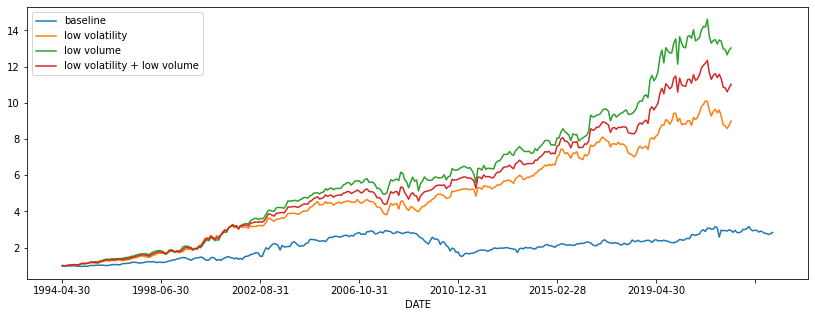

In [118]:
(1+lmh_baseline).cumprod().plot(figsize=(14,5), label='baseline')
(1+lmh_lowvolat).cumprod().plot(label='low volatility')
(1+lmh_lowvolume).cumprod().plot(label='low volume')
(1+combine).cumprod().plot(label='low volatility + low volume')

plt.legend()

## Strategy 4: Models

### Predict 'RET' using XGBoost Model 

In [112]:
import xgboost as xgb

date_list = sorted(df.DATE.drop_duplicates())

columns = ['lag_BM', 'lag_CFP', 'lag_EP', 'lag_TEV', 'lag_EM',
       'lag_SP', 'lag_GP', 'lag_OP', 'lag_ROA', 'lag_ROE', 'lag_PM','lag_AG', 'lag_IG',
       'lag_SG', 'lag_IVG','lag_IC', 'lag_IA', 'lag_Accruals', 'lag_NOA', 'lag_NWCC', 'lag_Leverage']

df['xgb_pred'] = np.nan

for i in range(1,len(date_list)):
    train = df.loc[df.DATE == date_list[i-1]].dropna(subset=columns)
    X, y = train[columns], train['RET']
    
    X_pred = pd.DataFrame(df.loc[df.DATE == date_list[i], columns])
    
    regout = xgb.XGBRegressor(n_estimators=100).fit(X, y)

    df.loc[df.DATE == date_list[i], 'xgb_pred'] = regout.predict(X_pred)

In [119]:
xgbmodel = df.loc[df.DATE > '1996-02-29'].dropna(subset=['xgb_pred'])
xgbmodel['xgb_quintile'] = \
        xgbmodel.groupby('DATE')['xgb_pred'].apply(quintiles)
xgbmodel.groupby('xgb_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
xgb_quintile,,,,,,,,
1,23632.0,0.011551,0.104606,-0.806948,-0.039977,0.011235,0.063056,2.135168
2,23454.0,0.009744,0.087749,-0.748231,-0.036877,0.009882,0.055955,1.380952
3,23438.0,0.009863,0.084186,-0.832263,-0.034895,0.011227,0.055111,0.861042
4,23454.0,0.009186,0.087262,-0.700413,-0.036360,0.010542,0.054282,1.780953
5,23569.0,0.010704,0.095753,-0.868645,-0.036697,0.011065,0.058188,1.508475


In [120]:
hml_xgb = xgbmodel.groupby(['xgb_quintile','DATE'])['RET'].mean().loc[5]  \
                    - xgbmodel.groupby(['xgb_quintile','DATE'])['RET'].mean().loc[1]

mean = hml_xgb.mean()
std = hml_xgb.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow xgboost'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102
low volatility + low volume,0.007476,0.027515,0.941194
highminuslow xgboost,-0.000944,0.031436,-0.104075


### Predict 'RET' using Random Forest

In [121]:
date_list = sorted(df.DATE.drop_duplicates())

columns = ['lag_BM', 'lag_CFP', 'lag_EP', 'lag_TEV', 'lag_EM',
       'lag_SP', 'lag_GP', 'lag_OP', 'lag_ROA', 'lag_ROE', 'lag_PM','lag_AG', 'lag_IG',
       'lag_SG', 'lag_IVG','lag_IC', 'lag_IA', 'lag_Accruals', 'lag_NOA', 'lag_NWCC', 'lag_Leverage']

rfmodel = df.dropna(subset=columns)
rfmodel['rf_pred'] = np.nan

for i in range(1,len(date_list)):
    train = rfmodel.loc[rfmodel.DATE == date_list[i-1]].dropna(subset=columns)
    X, y = train[columns], train['RET']
    
    X_pred = pd.DataFrame(rfmodel.loc[rfmodel.DATE == date_list[i], columns])
    
  
    regout = RandomForestRegressor().fit(X, y)

    rfmodel.loc[rfmodel.DATE == date_list[i], 'rf_pred'] = regout.predict(X_pred)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [122]:
rfmodel = rfmodel.loc[rfmodel.DATE > '1996-02-29'].dropna(subset=['rf_pred'])
rfmodel['rf_quintile'] = \
        rfmodel.groupby('DATE')['rf_pred'].apply(quintiles)
rfmodel.groupby('rf_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
rf_quintile,,,,,,,,
1,15467.0,0.011750,0.110784,-0.759162,-0.042548,0.011719,0.066039,2.135168
2,15272.0,0.011088,0.089594,-0.832263,-0.036768,0.010569,0.059406,0.822304
3,15276.0,0.010419,0.084746,-0.594777,-0.035892,0.010539,0.056780,0.689058
4,15272.0,0.008785,0.085163,-0.522130,-0.036752,0.009299,0.054213,1.780953
5,15394.0,0.009705,0.093916,-0.652757,-0.039614,0.009587,0.057758,0.977099


In [123]:
hml_rf = rfmodel.groupby(['rf_quintile','DATE'])['RET'].mean().loc[5]  \
                    - rfmodel.groupby(['rf_quintile','DATE'])['RET'].mean().loc[1]

mean = hml_rf.mean()
std = hml_rf.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow randomforest'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102
low volatility + low volume,0.007476,0.027515,0.941194
highminuslow xgboost,-0.000944,0.031436,-0.104075
highminuslow randomforest,-0.002199,0.042570,-0.178923


### Predict 'RET' using Linear Regression

In [124]:
columns = ['lag_BM', 'lag_CFP', 'lag_EP', 'lag_TEV', 'lag_EM',
       'lag_SP', 'lag_GP', 'lag_OP', 'lag_ROA', 'lag_ROE', 'lag_PM','lag_AG', 'lag_IG',
       'lag_SG', 'lag_IVG','lag_IC', 'lag_IA', 'lag_Accruals', 'lag_NOA', 'lag_NWCC', 'lag_Leverage']

lrmodel = df.dropna(subset=columns)
lrmodel['lr_pred'] = np.nan

for i in range(1,len(date_list)):
    
    X, y = lrmodel.loc[lrmodel.DATE == date_list[i-1], columns], lrmodel.loc[lrmodel.DATE == date_list[i-1], 'RET']
    X_pred = pd.DataFrame(lrmodel.loc[lrmodel.DATE == date_list[i], columns])
    
    regout = sm.OLS(endog=y, exog=X).fit()

    lrmodel.loc[lrmodel.DATE == date_list[i], 'lr_pred'] = regout.predict(X_pred)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [125]:
lrmodel = lrmodel.loc[lrmodel.DATE > '1996-02-29'].dropna(subset=['lr_pred'])
lrmodel['lr_quintile'] = lrmodel.groupby('DATE')['lr_pred'].apply(quintiles)
lrmodel.groupby('lr_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
lr_quintile,,,,,,,,
1,15467.0,0.008250,0.102740,-0.832263,-0.042908,0.008625,0.060831,2.135168
2,15272.0,0.010451,0.090962,-0.652757,-0.036260,0.010772,0.057882,1.468016
3,15276.0,0.010192,0.088911,-0.639682,-0.036301,0.010538,0.056123,1.780953
4,15272.0,0.011206,0.086613,-0.638604,-0.035307,0.011140,0.057555,0.777273
5,15394.0,0.011677,0.096615,-0.632196,-0.040501,0.010474,0.060903,0.977099


In [126]:
hml_lr = lrmodel.groupby(['lr_quintile','DATE'])['RET'].mean().loc[5]  \
                    - lrmodel.groupby(['lr_quintile','DATE'])['RET'].mean().loc[1]

mean = hml_lr.mean()
std = hml_lr.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow linear'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102
low volatility + low volume,0.007476,0.027515,0.941194
highminuslow xgboost,-0.000944,0.031436,-0.104075
highminuslow randomforest,-0.002199,0.042570,-0.178923
highminuslow linear,0.003600,0.037216,0.335064


In [127]:
def regfun(df, columns):
    X, y = df[columns], df['RET']
    X = sm.add_constant(X)
    results = sm.OLS(endog=y, exog=X).fit()
    return results.params

columns = ['lag_BM', 'lag_CFP', 'lag_EP', 'lag_TEV', 'lag_EM',
       'lag_SP', 'lag_GP', 'lag_OP', 'lag_ROA', 'lag_ROE', 'lag_PM','lag_AG', 'lag_IG',
       'lag_SG', 'lag_IVG','lag_IC', 'lag_IA', 'lag_Accruals', 'lag_NOA', 'lag_NWCC', 'lag_Leverage']

lrmodel = df.dropna(subset=columns)
lrmodel['lr_pred2'] = np.nan

allparams = lrmodel.groupby('DATE').apply(regfun, columns)
rollparams = allparams.rolling(120).mean().shift()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [128]:
lrmodel = lrmodel.merge(rollparams, how='left', on='DATE', suffixes=('','_coef'))

In [129]:
lrmodel['lr_pred2']=lrmodel['const']+lrmodel['lag_BM']*lrmodel['lag_BM_coef']\
        +lrmodel['lag_CFP']*lrmodel['lag_CFP_coef']+lrmodel['lag_EP']*lrmodel['lag_EP_coef'] \
        +lrmodel['lag_TEV']*lrmodel['lag_TEV_coef']+lrmodel['lag_EM']*lrmodel['lag_EM_coef'] \
        +lrmodel['lag_SP']*lrmodel['lag_SP_coef']+lrmodel['lag_GP']*lrmodel['lag_GP_coef'] \
        +lrmodel['lag_OP']*lrmodel['lag_OP_coef']+lrmodel['lag_ROA']*lrmodel['lag_ROA_coef'] \
        +lrmodel['lag_ROE']*lrmodel['lag_ROE_coef']+lrmodel['lag_PM']*lrmodel['lag_PM_coef'] \
        +lrmodel['lag_AG']*lrmodel['lag_AG_coef']+lrmodel['lag_IG']*lrmodel['lag_IG_coef'] \
        +lrmodel['lag_SG']*lrmodel['lag_SG_coef']+lrmodel['lag_IVG']*lrmodel['lag_IVG_coef'] \
        +lrmodel['lag_IC']*lrmodel['lag_IC_coef']+lrmodel['lag_IA']*lrmodel['lag_IA_coef'] \
        +lrmodel['lag_Accruals']*lrmodel['lag_Accruals_coef']+lrmodel['lag_NOA']*lrmodel['lag_NOA_coef'] \
        +lrmodel['lag_NWCC']*lrmodel['lag_NWCC_coef']+lrmodel['lag_Leverage']*lrmodel['lag_Leverage_coef']

In [130]:
lrmodel = lrmodel.loc[lrmodel.DATE > '1996-02-29'].dropna(subset=['lr_pred2'])
lrmodel['lr_quintile'] = \
        lrmodel.groupby('DATE')['lr_pred2'].apply(quintiles)
lrmodel.groupby('lr_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
lr_quintile,,,,,,,,
1,11082.0,0.010281,0.091812,-0.832263,-0.034798,0.010028,0.054030,2.135168
2,10950.0,0.010216,0.078866,-0.608174,-0.031920,0.011115,0.053722,0.498287
3,10951.0,0.009699,0.081172,-0.638604,-0.031897,0.010454,0.052919,0.897983
4,10950.0,0.009085,0.083128,-0.479702,-0.035395,0.009659,0.053766,0.977099
5,11035.0,0.011372,0.094054,-0.594777,-0.039697,0.012791,0.062524,1.780953


In [131]:
hml_lr = lrmodel.groupby(['lr_quintile','DATE'])['RET'].mean().loc[5]  \
                    - lrmodel.groupby(['lr_quintile','DATE'])['RET'].mean().loc[1]

mean = hml_lr.mean()
std = hml_lr.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow linear 2'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102
low volatility + low volume,0.007476,0.027515,0.941194
highminuslow xgboost,-0.000944,0.031436,-0.104075
highminuslow randomforest,-0.002199,0.042570,-0.178923
highminuslow linear,0.003600,0.037216,0.335064
highminuslow linear 2,0.001097,0.032767,0.115966


### Decision Tree

In [132]:
from sklearn.tree import DecisionTreeRegressor

date_list = sorted(df.DATE.drop_duplicates())

columns = ['lag_BM', 'lag_CFP', 'lag_EP', 'lag_TEV', 'lag_EM',
       'lag_SP', 'lag_GP', 'lag_OP', 'lag_ROA', 'lag_ROE', 'lag_PM','lag_AG', 'lag_IG',
       'lag_SG', 'lag_IVG', 'lag_IC', 'lag_IA', 'lag_Accruals', 'lag_NOA', 'lag_NWCC', 'lag_Leverage']

dtmodel = df.dropna(subset=columns)
dtmodel['dt_pred'] = np.nan

for i in range(1,len(date_list)):
    train = dtmodel.loc[dtmodel.DATE == date_list[i-1]].dropna(subset=columns)
    X, y = train[columns], train['RET']
    
    X_pred = pd.DataFrame(dtmodel.loc[dtmodel.DATE == date_list[i], columns])
    
  
    regout = DecisionTreeRegressor().fit(X, y)

    dtmodel.loc[dtmodel.DATE == date_list[i], 'dt_pred'] = regout.predict(X_pred)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [133]:
dtmodel = dtmodel.loc[dtmodel.DATE > '1996-02-29'].dropna(subset=['dt_pred'])
dtmodel['dt_quintile'] = \
        dtmodel.groupby('DATE')['dt_pred'].apply(quintiles)
dtmodel.groupby('dt_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
dt_quintile,,,,,,,,
1,15500.0,0.012705,0.111471,-0.759162,-0.041413,0.011823,0.066702,2.135168
2,15271.0,0.011420,0.089087,-0.832263,-0.036900,0.011332,0.059267,0.822304
3,15267.0,0.009869,0.084341,-0.609349,-0.036080,0.010648,0.056790,0.732558
4,15278.0,0.008780,0.085038,-0.564085,-0.036822,0.008842,0.054230,1.780953
5,15365.0,0.008959,0.093976,-0.652757,-0.040317,0.009133,0.057182,0.977099


In [134]:
hml_dt = dtmodel.groupby(['dt_quintile','DATE'])['RET'].mean().loc[5]  \
                    - dtmodel.groupby(['dt_quintile','DATE'])['RET'].mean().loc[1]

mean = hml_dt.mean()
std = hml_dt.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow decisiontree'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,0.003622,0.038169,0.328757
low volatility,0.006877,0.027648,0.861655
low volume,0.008075,0.031042,0.901102
low volatility + low volume,0.007476,0.027515,0.941194
highminuslow xgboost,-0.000944,0.031436,-0.104075
highminuslow randomforest,-0.002199,0.042570,-0.178923
highminuslow linear,0.003600,0.037216,0.335064
highminuslow linear 2,0.001097,0.032767,0.115966
highminuslow decisiontree,-0.004030,0.039308,-0.355183
